Dataset : [Air Passengers](https://www.kaggle.com/datasets/ashfakyeafi/air-passenger-data-for-time-series-analysis)

# Import Library and Dataset 

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

In [146]:
url = 'https://raw.githubusercontent.com/Yogaaprila/MC_Data/main/AirPassengers.csv'
data = pd.read_csv(url)
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
data.set_index('Month', inplace=True)
pd.set_option('display.max_columns',None)

data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [148]:
data.tail()

,#Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


In [150]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


# Time Series Plot

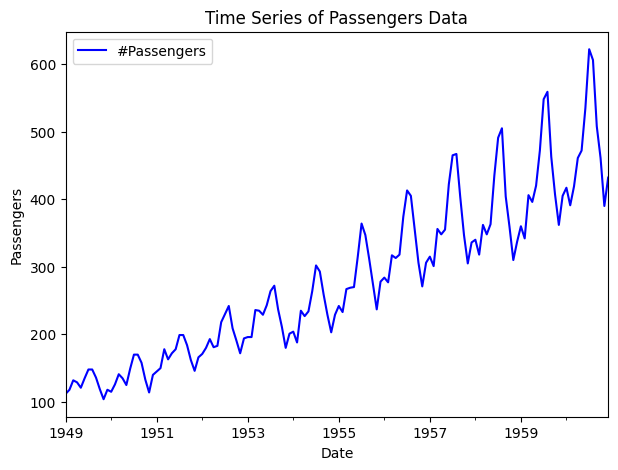

In [152]:
data.plot(title="Time Series of Passengers Data", figsize=(7, 5), color='blue')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()

The data shows an upward trend and a seasonal pattern

# Summarical Statistics

In [13]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
#Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


# Data Preprocessing

## Outliers

<Axes: >

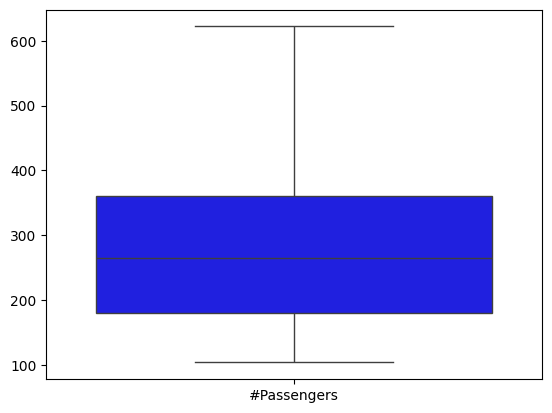

In [15]:
sns.boxplot(data, color='blue')

Data has not contain outliers.

## Stationary Test

In [17]:
# Stationary test using Augmented Dickey-Fuller (ADF) test
result = adfuller(data)
print("ADF Statistic:", result[0])
print("p-value:", result[1])
if result[1] <= 0.05:
    print("Data is stationary.")
else:
    print("Data is non-stationary. Differencing required.")

ADF Statistic: 0.8153688792060597
p-value: 0.9918802434376411
Data is non-stationary. Differencing required.


In [19]:
data_diff = data.diff().dropna()

# Stationary Test
result = adfuller(data_diff)
print("ADF Statistic:", result[0])
print("p-value:", result[1])
if result[1] <= 0.05:
    print("Differenced data is stationary.")
else:
    print("Differenced data is non-stationary. Further differencing required.")

ADF Statistic: -2.829266824169992
p-value: 0.0542132902838265
Differenced data is non-stationary. Further differencing required.


Because data is still non stationary. To handle this, apply **second-order differencing**.

In [21]:
data_diff2 = data.diff().diff().dropna()

# Stationary test
result = adfuller(data_diff2)
print("ADF Statistic:", result[0])
print("p-value:", result[1])
if result[1] <= 0.05:
    print("Differenced data is stationary.")
else:
    print("Differenced data is non-stationary. Further differencing required.")

ADF Statistic: -16.384231542468527
p-value: 2.732891850014085e-29
Differenced data is stationary.


Data is stationary, obtained order of differencing (d) is 2.

## ACF and PACF Plot

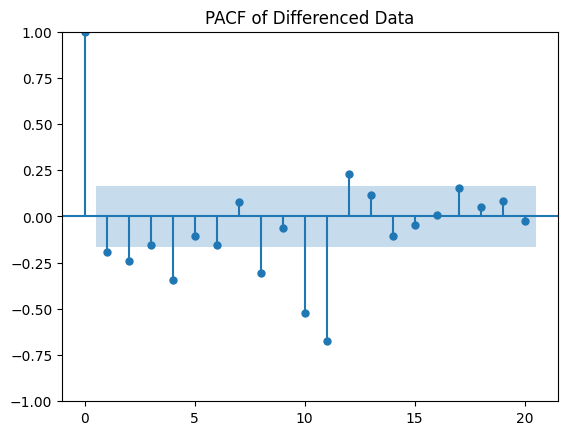

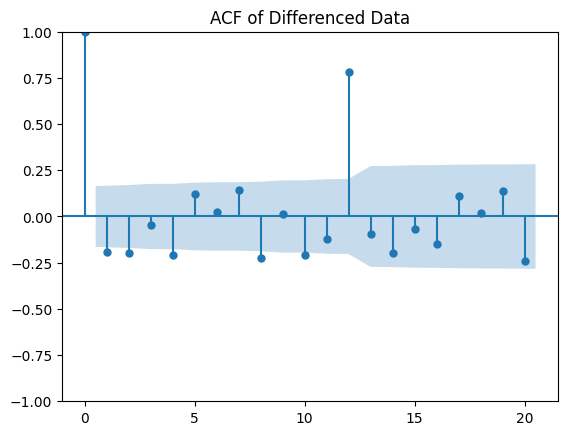

In [89]:
plot_pacf(data_diff2, lags=20, title="PACF of Differenced Data")
plot_acf(data_diff2, lags=20, title="ACF of Differenced Data")

plt.show()

from ACF and PACF chart obtained :
1. order of autoregressive(p) is 11. (obtained from PACF)
2. order of differencing(d) is 2.
3. order of moving average(q) is 11. (obtained from ACF)

# Modeling

## Fit ARIMA (p,d,q) Model

In [96]:
# Define Parameter (p,d,q)
p, d, q = 11, 2, 11

# Fit ARIMA Model
model = ARIMA(data['#Passengers'], order=(p, d, q))
arima_model = model.fit()

## Model Summary

In [51]:
# Model Summary
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:               ARIMA(11, 2, 11)   Log Likelihood                -551.470
Date:                Mon, 06 Jan 2025   AIC                           1148.939
Time:                        10:50:02   BIC                           1216.923
Sample:                    01-01-1949   HQIC                          1176.565
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7776      0.399     -1.951      0.051      -1.559       0.004
ar.L2         -0.9390      0.065    -14.544      0.000      -1.066      -0.812
ar.L3         -0.8211      0.385     -2.134      0.0

## Make Prediction

In [53]:
data['Prediction'] = arima_model.fittedvalues

In [55]:
data.head()

,#Passengers,Prediction
Month,,
1949-01-01,112,0.000000
1949-02-01,118,168.064617
1949-03-01,132,123.993235
1949-04-01,129,146.217831
1949-05-01,121,124.763807


## Model Evaluation

In [124]:
# Main Metric
mae = mean_absolute_error(data['#Passengers'][1:], data['Prediction'][1:])
print("Mean Absolute Error:", mae)

mape = mean_absolute_percentage_error(data['#Passengers'][1:], data['Prediction'][1:])
print("Mean Absolute Percentage Error:", mape)

# Support Metric
mse = mean_squared_error(data['#Passengers'][1:], data['Prediction'][1:])
print("Mean Squared Error:", mse)

rmse = sqrt(mean_squared_error(data['#Passengers'][1:], data['Prediction'][1:]))
print("Root Mean Squared Error:", rmse)

Mean Absolute Error: 8.799122384234277
Mean Absolute Percentage Error: 0.03672330658684733
Mean Squared Error: 139.87599717940503
Root Mean Squared Error: 11.826918329785027


## Visualize Result

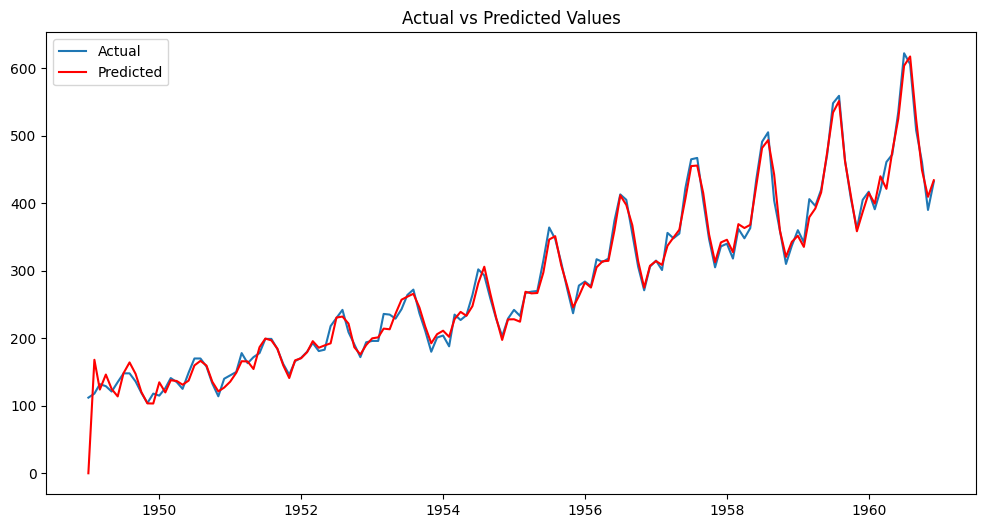

In [59]:
plt.figure(figsize=(12, 6))
plt.plot(data['#Passengers'], label='Actual')
plt.plot(data['Prediction'], color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

## Forecasting 

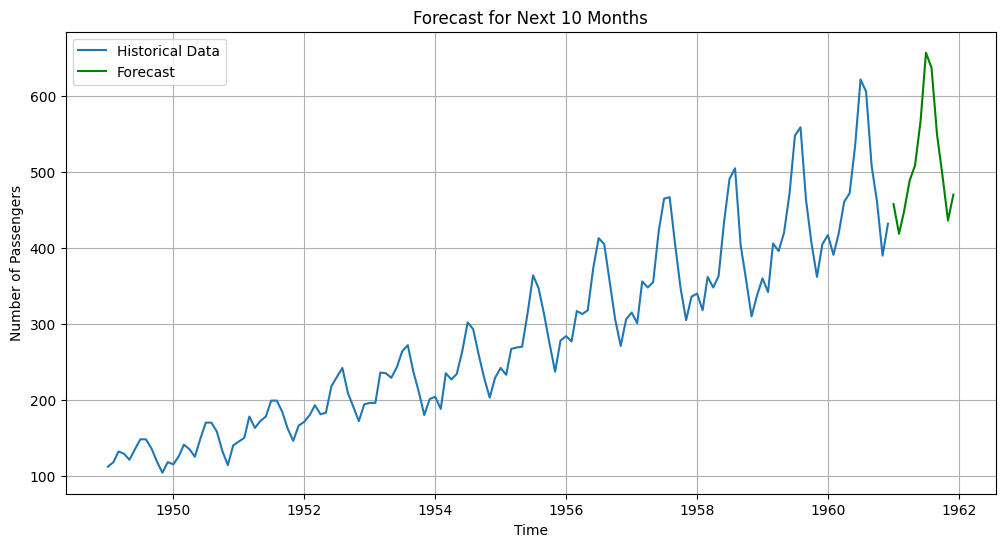

In [76]:
# Forecast next 12 months
forecast_steps = 12
forecast = arima_model.forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=data.index[-1] + pd.offsets.MonthBegin(1), periods=forecast_steps, freq='MS')
forecast_series = pd.Series(forecast, index=forecast_index)

# Plot Forecast
plt.figure(figsize=(12, 6))
plt.plot(data['#Passengers'], label='Historical Data')
plt.plot(forecast_series, label='Forecast', color='green')
plt.title('Forecast for Next 10 Months')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid()
plt.show()

# Conclusion

1. Data Insights
The data shows an **upward trend** and a **seasonal pattern**.

2. ARIMA Model Results
An ARIMA(11,2,11) model was developed, with the following evaluation scores:

 | **Metric**           | **Value**   |
|-----------------------|-------------|
| **Main Metrics**      |             |
| Mean Absolute Error (MAE)      | 8.7991      |
| Mean Absolute Percentage Error (MAPE) | 0.0367      |
| **Support Metrics**   |             |
| Mean Squared Error (MSE)        | 139.8760    |
| Root Mean Squared Error (RMSE)  | 11.8269    |



    
4. Forecasted Airline Passengers for the Next Year :

| Month       | # Passengers |  
|-------------|--------------|  
| 1961-01-01  | 457.838854   |  
| 1961-02-01  | 418.740886   |  
| 1961-03-01  | 448.587191   |  
| 1961-04-01  | 488.774842   |  
| 1961-05-01  | 508.757295   |  
| 1961-06-01  | 567.303285   |  
| 1961-07-01  | 657.233423   |  
| 1961-08-01  | 637.471689   |  
| 1961-09-01  | 549.086862   |  
| 1961-10-01  | 495.612969   |  
| 1961-11-01  | 436.263882   |  
| 1961-12-01  | 470.375637   |  

4. Recommendation :
The data indicates a strong seasonal pattern. To improve model accuracy, it is recommended to use the **SARIMA** model.
